# MPlot tutorial (ts_step = 2)

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'PulsusParadoxus'.

## What is an MPlot?
MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!

**Note**

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed. You can check more examples in [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view). You will also find lots more datasets at his GoogleDrive. [This powerpoint](https://www.slideserve.com/mickie/ucr-time-series-semantic-segmentation-archive-powerpoint-ppt-presentation) explains the content of some of them in a simple way, including the Pulsus Paradoxus dataset.

## Notebook configuration
### Parameters

The parameters in this notebook are only some of the input parameters you can define for the *06-Mplot* notebook. In that notebook the configuration parameters are included in the first cell and fully explained as needed. 

Here you got:

- `verbose`. If `> 0` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `cuda_device`. Integer used to define the GPU machine to be used for computation. Please ensure it is an id number valid for the built docker (check your .env file to know the valid ids)
- `execute_01`. Put this flag to true in case you have never executed the 01_<> notebook for the PulsusParadoxus dataset. Please change it to false one the celss in the section `Execute '1` have already been executed. It does not take very long, but it is some time ;).

In [1]:
#| export
# Configuration paramaters
verbose                       = 1
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1
execute_01                    = False
move_files                    = True

In [2]:
if move_files:
    import _clean_yaml as yml
    example = "pulsus_paradoxus_SPO2"
    yml.copy_and_verify_yaml('mi-santamaria', 'deepvats', example, verbose = 0)

In [3]:
! head -n 17  ~/work/nbs_pipeline/config/base.yaml

#########################################################
########### NBS - PIPELINE CONFIGURATION FILE ###########
#########################################################
###### Author: Maria Inmaculada Santamaria-Valenzuela   #
###### Date: 08-2023                                    #
#########################################################

##########################
# Basic user preferences #
##########################
user_preferences: 
  #Weights & biases
  # Whether to use or not wandb for experiment tracking
  use_wandb: &use_wandb true
  wdb:
user: &wdb_user mi-santamaria
project_name: &wdb_project deepvats


In [4]:
yml.clean_all_examples("<>", "<>", verbose = 0)

In [4]:
! head -n 17  ~/work/nbs_pipeline/config/examples/{example}/base.yaml

#########################################################
########### NBS - PIPELINE CONFIGURATION FILE ###########
#########################################################
###### Author: Maria Inmaculada Santamaria-Valenzuela   #
###### Date: 08-2023                                    #
#########################################################

##########################
# Basic user preferences #
##########################
user_preferences: 
  #Weights & biases
  # Whether to use or not wandb for experiment tracking
  use_wandb: &use_wandb true
  wdb:
    user: &wdb_user <>
    project_name: &wdb_project <>


In [6]:
#| export
# Configuration paramaters
verbose                       = 1
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1
execute_01                    = False

In [7]:
print("--- Check parameters ---")
print(
    "verbose (for printing or not messages):", verbose, "\n",
    "check_memory_usage (for evaluating the current gpu memor status)", check_memory_usage, "\n",
    "time_flag:", time_flag, "\n",
    "reset_kernel:",reset_kernel, "\n",
    "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
verbose (for printing or not messages): 1 
 check_memory_usage (for evaluating the current gpu memor status) True 
 time_flag: True 
 reset_kernel: False 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [8]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

## Import libraries

In [9]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
warnings.simplefilter('always', UserWarning)
import os
import sys
sys.path.append(os.path.abspath('..'))
import dvats.config as cfg_
import dvats.mplots as mplots
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7ff30e97e260>

















## Execute 01 notebook
If you haven't executed the 01_<> notebook, execute the next 5 code cells

Please be sure that you have already downloaded the PulsusParadoxus dataset into your local path 
deepvats\..\data\ as .csv . You can check it with the next cell. It can be downloaded from [segData](https://drive.google.com/file/d/1mJs_FSjSnffw2xPJhu3SlES2kXSCMoNy/view). Unzip the folder and get the `PulsusParadoxusSP02_30_10000.txt` file and change the extension to `.csv` so you can execute the code. There are some utilities function if you can do it directly here in the `nbs\mplots.ipybn` notebook, but they are not relevant for this tutorial. If you want, just take a look and if you think it is usefull, make a pull requests with the changes to add here the downloading lines using those utilities functions. Thanks!

In [10]:
#warnings.filterwarnings('ignore', category=UserWarning)
pulsus_path = "~/data/home/macu/data/PulsusParadoxusSP02_30_10000.csv"
pulsus_path = os.path.expanduser(pulsus_path)
print(pulsus_path)
! ls {pulsus_path}

/home/macu/data/home/macu/data/PulsusParadoxusSP02_30_10000.csv
ls: cannot access '/home/macu/data/home/macu/data/PulsusParadoxusSP02_30_10000.csv': No such file or directory


In [11]:
#-- For setting up the parameters
import os
import torch
from typing import Tuple, Dict

#-- Specific
from ploomber_engine import execute_notebook

##### Ensure the correct configuration for ploomber engine execution

In [12]:
filename = "01_dataset_artifact"
parameters = {
    'verbose'                       : 0,
    'show_plots'                    : False,
    'reset_kernel'                  : False,
    'pre_configured_case'           : False,
    'case_id'                       : 7,
    'frequency_factor'              : 1,
    'frequency_factor_change_alias' : True,
    'cuda_device'                   : torch.cuda.current_device()
}

In [13]:
def get_input_output(nb_id: int) -> Tuple[ str, str, Dict ]:
    print(filename)
    print(parameters)
    inbpath    = os.path.expanduser('~/work/nbs_pipeline')
    onbpath    = os.path.expanduser('~/work/nbs_pipeline/output')
    extension  = ".ipynb"
    reportname = filename+"-output"
    inputnb    = inbpath+"/"+filename+extension
    outputnb   = onbpath+"/"+reportname+extension
    print(f"Executing {inputnb} into {outputnb}")
    return inputnb, outputnb, parameters

##### Execute 01

In [14]:
if execute_01:
    warnings.simplefilter('ignore', UserWarning)
    inputnb, outputnb, parameters = get_input_output(1)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

## Initialize and Configurate Artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;The following cells can be skipped as they are configuration cells. Continue until the next warning.
    </div>
</div>

### Initialize Weights and Biases

In [15]:
#| export
wandb_api = wandb.Api()

### Setup CUDA

In [16]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 8
GPU | Used mem: 48
GPU | Memory Usage: [███-----------------] 17%


### Get configutation from yml
> This file used the configuration files './config/base.yml'

In [17]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [18]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

ScannerError: mapping values are not allowed here
  in "<unicode string>", line 18, column 12:
        version: &wdb_version 'latest' 
               ^

### Setup Weights & biases artiffact

In [ ]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_PulsusParadoxus"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

In [ ]:
job_type = 'MPlot'
job_type

## Start W&B Run

In [ ]:
#| export
if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;End of the skippable cells.
    </div>
</div>

## Get the time series data
### Get W&B train artifact

In [ ]:
#| export
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")

### Transform to dataframe

In [ ]:
#| export
df_train = train_artifact.to_df()

In [ ]:
#| export
if verbose > 0: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

## Check the MatrixProfile

In [ ]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

### Initialize parameters

In [ ]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = dvats.mplots.scamp.gpu_supported()
has_gpu_support

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

### Get the time series data

In [ ]:
df_train.shape

In [ ]:
# Use step for selecting values in position k*step 
ts_step = 2
ts_full = df_train.iloc[:, 0].values
ts = df_train.iloc[:, 0].values[::ts_step] #For some reason. Trying to follow MPlot-figures-ref

In [ ]:
mplots.plot_with_dots(
    time_series = ts, 
    title = "Pulsus Paradoxus SPO2", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False
)

### Build the MatrixProfile object

In [ ]:
pulsus_mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

### Choose window length
Eamon et all use ''approximately 1 pulsus'': m = 50. 
Let's see what does Fourier transform detect

In [ ]:
pulsus_mp.provide_lens(1)
pulsus_mp.dominant_lens

In [ ]:
mplots.plot_subsequence(
    TA = ts_full[:100], 
    sequence_i = 0,
    subsequence_len = pulsus_mp.subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

And what happens if we use the double?

In [ ]:
length = int(pulsus_mp.subsequence_len/ts_step)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = [0, length+1, 2*length+1],
    color = [ "blue", "orange", "purple"],
    resalt     = 3*[True],
    subsequence_len = length,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

This value seems to correspond to that idea of getting 'one pulsus' as subsequence length

### Compute the Matrix Profile

In [ ]:
pulsus_mp.subsequence_len = pulsus_mp.dominant_lens[0]*2*ts_step

In [ ]:
pulsus_mp.compute(
    verbose = 1,
    d = mplots.z_normalized_euclidean_distance, 
    method = 'stump'
)

In [ ]:
len(pulsus_mp.index)

### Visualization of the matrix profile

With the interactive plot we can visually check the motif and anomaly indexes.
The previous and next buttons can be used for going subsequence by subsequence whereas the Motif and Discord buttons show the associated subsequences.

In [ ]:
%matplotlib widget
pulsus_mp.plot_interactive(
    figsize = (8,8),
    verbose =  0
)

### Direct computation & related metadata

#### Motif

In [ ]:
pulsus_mp.get_motif_idx(verbose = verbose)

In [ ]:
print(pulsus_mp.motif_idx)
print(pulsus_mp.motif_nearest_neighbor_idx)
print(pulsus_mp.motif_nearest_neighbor_idx_left)
print(pulsus_mp.motif_nearest_neighbor_idx_right)


#### Discord/Anomaly

In [ ]:
pulsus_mp.get_anomaly_idx(verbose = verbose)

In [ ]:
print(pulsus_mp.discord_idx)
print(pulsus_mp.discord_nearest_neighbor_idx)
print(pulsus_mp.discord_nearest_neighbor_idx_left)
print(pulsus_mp.discord_nearest_neighbor_idx_right)

## Check the MPlot

### Build the MatrixProfilePlot object

In [ ]:
pulsus_mp.subsequence_len

In [ ]:
pulsus_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [ ]:
#| hide
print("MP_AB self_join", pulsus_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {pulsus_MPlot.DM_AB.shape}")
print("MP_AB method:", pulsus_MPlot.MP_AB.method)
print("DM_AB method:", pulsus_MPlot.DM_AB.method)

### Compute the Similarity Matrix

In [ ]:
pulsus_MPlot.subsequence_len

In [ ]:
len(ts)

In [ ]:
#ts[4499]

In [ ]:
mp_method = 'stump'
dm_method = 'stump'

In [ ]:
pulsus_MPlot.compute(
    mp_method           = mp_method, 
    dm_method           = dm_method,
    d                   = mplots.z_normalized_euclidean_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    subsequence_len     = pulsus_mp.subsequence_len,
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)

### Check the obtained values

In [ ]:
n_a = len(pulsus_MPlot.data)
n_b = len(pulsus_MPlot.data_b)
print("-- DM Expected dimensions -- ")
print("Rows: ", n_b - pulsus_MPlot.subsequence_len + 1)
print("Columns: ", n_a - pulsus_MPlot.subsequence_len + 1)
print(f"-- Obtained shape when computing using  {pulsus_MPlot.DM_AB.method} --")
print(pulsus_MPlot.DM_AB.shape)
print(f"-- MP dimension using {pulsus_MPlot.MP_AB.method}")
print(len(pulsus_MPlot.MP_AB.distances))
print("-- DM Values --")
print(pulsus_MPlot.DM_AB.distances)
print("-- MP values --")
print(pulsus_MPlot.MP_AB.distances)

### Visualize the plot

#### Reverse engineering to extract the position in the figure
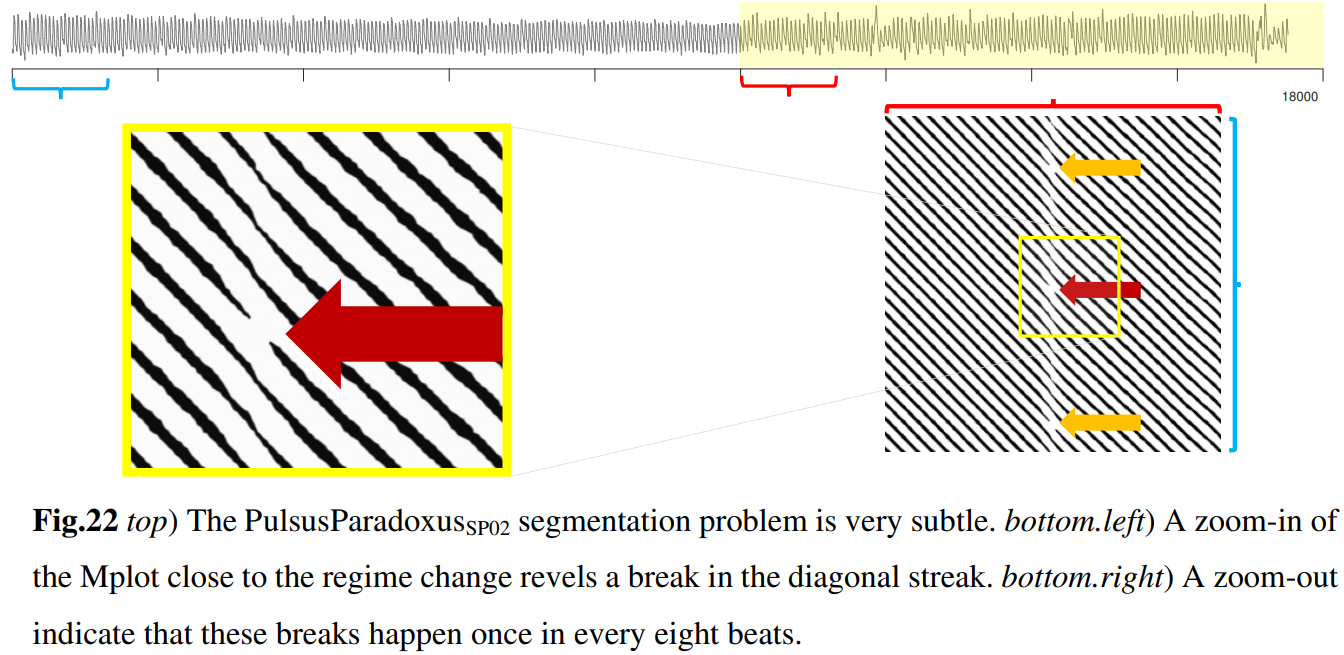

In [ ]:
fraction = 18000/(9*ts_step)
print(fraction)
approximated_position_in_eamonn_plot = 6*fraction + (fraction/2)
print(f"Approximated position in eammon's plot {approximated_position_in_eamonn_plot}")

In [ ]:
sequences_len = int(np.ceil(2*fraction/3))
sequences_len

In [ ]:
blue_final = int(sequences_len)
print(f"blue {0}-{blue_final}")
blue_sequence = ts[0:blue_final]
red_init = int(fraction*5)
red_final = red_init+sequences_len
print(f"red {red_init}-{red_final}")
red_sequence = ts[red_init:red_final]
init = max(0, pulsus_mp.motif_idx - pulsus_mp.subsequence_len)
final = int(init+sequences_len)
print(f"mp {init}-{final}")
mp_sequence = ts[init:final]

##### Motif found by MP

In [ ]:
dvats.utils.styled_print("Motif found using MP", size = '40px', weight = 'bold')
id = pulsus_mp.get_ordered_idx(0)
init = id-pulsus_mp.subsequence_len
final = init + sequences_len
dvats.utils.styled_print(f"Plotted: ts[{init},{final}] => {id} subsequence index changes to {id-init}", size = '20px')
dvats.utils.styled_print(f"Original index: ts[{init*ts_step},{final*ts_step}] | {id*ts_step}", size = '20px')

mplots.plot_subsequence(
    TA = mp_sequence, 
    sequence_i = id-init,
    subsequence_len = pulsus_mp.subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    TA_color = "grey",
    color = "#D80000",
    TA_name = "Pulsus Paradoxus (stride 2)",
    resalt = "True",
    title = "",
    TA_label = True,
    plot_name = "example_pulsus_mp_sequences_len_black_orange",
    anchor_pos =  (1.65, 0.5),
    legend_loc = "center right",
    anchor_right = 0.9,
    legend_size = 20
)

#### Red subsequence

In [ ]:
dvats.utils.styled_print("Red subsequence", size = '40px', weight = 'bold')
pos = int( red_init+(sequences_len/2) )
dvats.utils.styled_print(f"Plotted: ts[::{ts_step}][{red_init},{red_final}] | {pos} subsequence index changes to {pos-red_init}", size = '20px')
dvats.utils.styled_print(f"Original index: ts[{red_init*ts_step},{red_final*ts_step}] | {pos*ts_step}", size = '20px')

mplots.plot_subsequence(
    TA = red_sequence, 
    sequence_i = int(sequences_len/2),
    subsequence_len = pulsus_mp.subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    TA_color = "#CC0000",
    color = "blue",
    resalt = True,
    title = "",
    TA_label = True,
    TA_name = "Pulsus Paradoxus (stride 2)",
    plot_name = "example_pulsus_red_sequence_2_red_blue",
    plot_format = "svg",
    TA_alpha = 0.4,
    legend_size = 20,
    title_size = 20,
    plot_resolution = 10,
    fig_size = (12, 2.59),
    legend_loc = "center right",
    anchor_pos =  (1.7, 0.5),
    anchor_bottom = 0.1,
    anchor_top = 0.9,
    anchor_right = 0.9,
    anchor_left = 0.1
)


#### Blue subsequence

The motif is found each 8 beats. The first seem to be in the fourth beat. Let's check.

Take special care as in the plot they are computing with time steps of 2 for some case
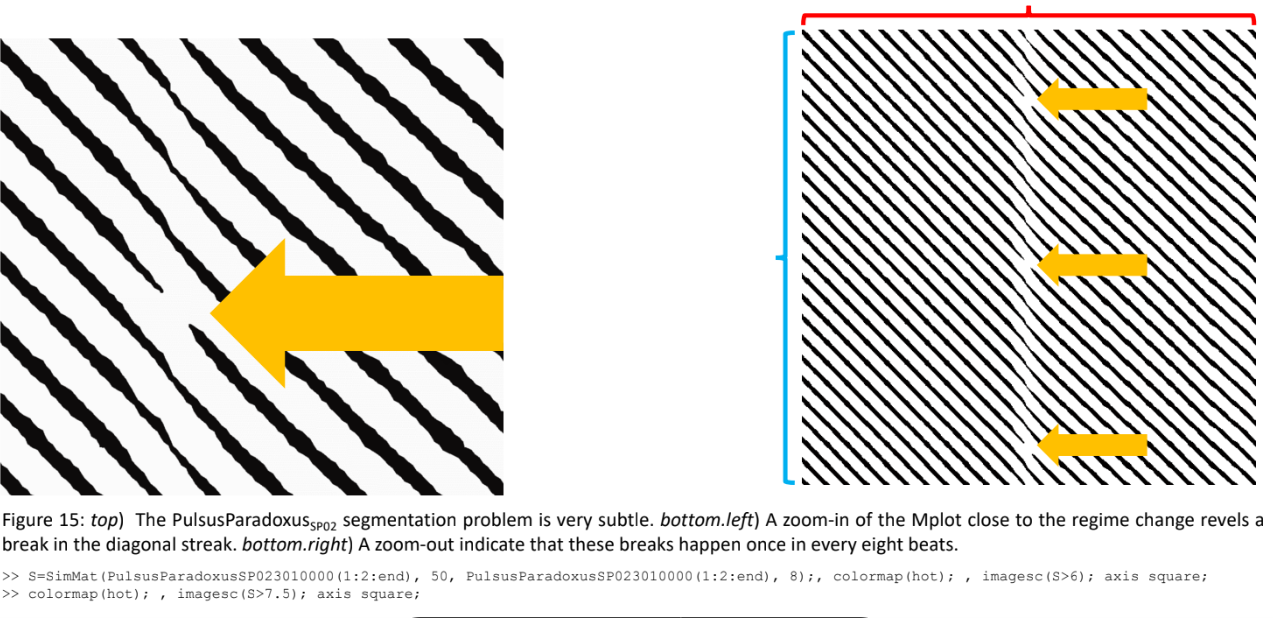

In [ ]:
pulsus_mp.subsequence_len

In [ ]:
m = pulsus_mp.subsequence_len

dvats.utils.styled_print("Blue subsequence", size = '40px', weight = 'bold')
pos=int(4*m/ts_step)
dvats.utils.styled_print(f"Plotted: ts[::{ts_step}][{0},{blue_final}] | {pos} ", size = '20px')
dvats.utils.styled_print(f"Original index: ts[{0},{blue_final*ts_step}] | {pos*ts_step}", size = '20px')
first_i = int(4*pulsus_mp.subsequence_len)

mplots.plot_subsequence(
    TA = blue_sequence, 
    sequence_i = pos,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    color = "orange",
    plot_name = "example_pulsus_blue_sequence_2_blue_orange",
    plot_format = "svg",
    TA_color = "blue",
    TA_alpha = 0.4,
    TA_name = "Pulsus Paradoxus"
)
pos = int(pos+8*m/ts_step)
dvats.utils.styled_print(f"Plotted: ts[::{ts_step}][{0},{blue_final}] | {pos}", size = '20px')
dvats.utils.styled_print(f"Original index: ts[{0},{blue_final*ts_step}] | {pos*ts_step}", size = '20px')
mplots.plot_subsequence(
    TA = blue_sequence, 
    sequence_i = pos,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    color = "orange",
    plot_name = "example_pulsus_blue_sequence_2_blue_orange_2",
    plot_format = "svg",
    TA_color = "blue",
    TA_alpha = 0.4
)
pos = int(pos+8*m/ts_step)
dvats.utils.styled_print(f"Plotted: ts[::{ts_step}][{0},{blue_final}] | {pos} ", size = '20px')
dvats.utils.styled_print(f"Original index: ts[{0},{blue_final*ts_step}] | {pos*ts_step}", size = '20px')
mplots.plot_subsequence(
    TA = blue_sequence, 
    sequence_i = pos,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    color = "orange",
    plot_name = "example_pulsus_blue_sequence_2_blue_orange_3",
    plot_format = "svg",
    TA_color = "blue",
    TA_alpha = 0.4
)


In [ ]:
m    = pulsus_mp.subsequence_len
pos  = int(4*m/ts_step)
pos2 = int(pos+8*m/ts_step)
pos3 = int(pos2+8*m/ts_step)
mplots.plot_subsequence(
    TA              = blue_sequence, 
    sequence_i      = [pos, pos2, pos3],
    color           = ["green", "orange", "red"],
    resalt          = True,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_name = "example_pulsus_blue_sequence_2_blue_orange",
    plot_format = "svg",
    TA_color = "blue",
    TA_alpha = 0.4,
    TA_name = "Pulsus Paradoxus (stride 2)",
    legend_size = 20,
    title = "",
    plot_resolution = 10,
    fig_size = (12, 2.59),
    legend_loc = "center right",
    anchor_pos =  (1.7, 0.5),
    anchor_bottom = 0.1,
    anchor_top = 0.9,
    anchor_right = 0.9,
    anchor_left = 0.1,
    TA_label = True
)

In [ ]:
%matplotlib widget
# Max points to plot
pulsus_MPlot.MP_AB.max_points = 3000
pulsus_MPlot.MP_AB.plot_interactive(verbose = 1, figsize=(8,7))

In [ ]:
t0 = int(max(0,np.floor(approximated_position_in_eamonn_plot-pulsus_MPlot.subsequence_len*2)))
t1 = int(min(np.ceil(approximated_position_in_eamonn_plot+pulsus_MPlot.subsequence_len*2), len(pulsus_MPlot.data)))
mplots.plot_with_dots(
    time_series = pulsus_MPlot.data[t0:t1],
    title = "Checking expected motif", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (6,4)
)

It seems to be a very similar subsequence. Can't compute the distance as I don't know the correct initial index.

#### Setting up a threshold

It has been checked that, at least for pulsus raxodus, STUMP separates more the distances than SCAMP, so the proposed thresholds show similar plots for the specific case.

In [ ]:
# Threshold per method
threshold_scamp = 10.72
threshold_stump = 7.6
#Select the threshold for the method used for the computation
threshold = threshold_stump if pulsus_MPlot.DM_AB.method == 'stump' else threshold_scamp

#### Visualizing the MPlot in gray scale

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;TODO: check, the gray_color flag is in the opposite way... 
    </div>
</div>

In [ ]:
print(f"Threshold: {threshold} | Mehod: {pulsus_MPlot.DM_AB.method}")

pulsus_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = 6,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'Variable 0: MPlot | ' + pulsus_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = False
)

#### Zoom!

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;Remember that in MPlots zooming in-out is not recommended due to the approximations. Thus. We directly show the specific part 
    </div>
</div>

In [ ]:
spaces_len = int(18000/9)
print(spaces_len)
sequence_len = int(np.ceil(2*spaces_len/3))
print(sequence_len)
#sequence_len = int(sequence_len/ts_step)
#print(sequence_len)

In [ ]:
#Pattern location following Eamonn et al.
c_min = int((np.floor(spaces_len*5+spaces_len/2)+2*pulsus_mp.subsequence_len)/ts_step)
c_max = c_min + int(sequence_len/ts_step)
r_min = max(0,int(np.floor(0/ts_step)))
#r_max = min(int(np.ceil(sequence_len/ts_step))+1, pulsus_MPlot.DM_AB.shape[0])
r_max = r_min + int(sequence_len/ts_step)

print(f"R({r_min}, {r_max}) C({c_min}, {c_max}) ")
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
#Pattern location following Eamonn et al.
c_min = int(np.floor(spaces_len*5/ts_step))+pulsus_mp.subsequence_len
c_max = int(np.ceil((spaces_len*5+sequence_len)/ts_step))+1
r_min = max(0,int(np.floor(0/ts_step)))
r_max = min(int(np.ceil(sequence_len/ts_step))+1, pulsus_MPlot.DM_AB.shape[0])

print(f"R({r_min}, {r_max}) C({c_min}, {c_max}) ")
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
len(ts)

In [ ]:
pulsus_MPlot.DM_AB

In [ ]:
if verbose > 0: print("Threshold: ", threshold)
pulsus_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (8,5),
    less_labels  = True,
    r_min        = 0,
    r_max        = 1000,
    c_min        = 4500,
    c_max        = 6000,
    dm_filter    = mplots.threshold_interval,
    th_min       = -np.inf,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    verbose      = 1
)

##### Checking the pattern by the right

In [ ]:
dvats.utils.styled_print("The blank spaces by the right", size = '40px', weight = 'bold')
pos=5896
init_ = 4500
end_ = 6000
dvats.utils.styled_print(f"Plotted: ts[::{ts_step}][{init_},{end_}] | {pos} subsequence index changes to {pos-red_init}", size = '20px')
dvats.utils.styled_print(f"Original index: ts[{init_},{end_*ts_step}] | {pos*ts_step}", size = '20px')
first_i = int(4*pulsus_mp.subsequence_len)
m = pulsus_mp.subsequence_len
mplots.plot_subsequence(
    TA = ts[init_:end_], 
    sequence_i = pos-init_,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    TA_color = "black",
    color = "orange"
)

#### Zoom with colors!

In [ ]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
print("Threshold: ", threshold)
pulsus_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    less_labels  = True,
    r_min        = 0,
    r_max        = 1000,
    c_min        = 4500,
    c_max        = 5500,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = True,
    plot_mp_flag = False,
    verbose      = 1
)

#### And what about computing only the part of the plot I need?

In [ ]:
pulsus_MPlot2 = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [ ]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
pulsus_MPlot2.compute(
    mp_method           = mp_method,
    dm_method           = dm_method,
    debug               = False,
    time_flag           = True,
    #allow_experimental  = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    c_min               = 0,
    c_max               = 1000,
    r_min               = 5000, 
    r_max               = 6000,
    max_points          = 5000,
    #nlens              = 5,
    subsequence_len     = pulsus_mp.subsequence_len,
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    verbose             = 1,
    threads             = 1,
    gpus                = [1]
)

In [ ]:
#pulsus_MPlot.DM_AB.distances[4500:5525,0:1025]
pulsus_MPlot.DM_AB.distances[0:1000,4500:5500]

In [ ]:
pulsus_MPlot2.DM_AB.distances

In [ ]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
print(pulsus_MPlot.DM_AB.shape)
print(pulsus_MPlot2.DM_AB.shape)

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;Take care... some dyslexia is beeing fixed here. Use columns as rows and rows as columns.
    </div>
</div>

In [ ]:
warnings.simplefilter('always', UserWarning)

In [ ]:
# The mistery of indexes is still being solved
print("Threshold: ", threshold)
pulsus_MPlot2.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    less_labels  = True,
    r_min        = 5000,
    r_max        = 6000,
    c_min        = 0,
    c_max        = 1000,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = False,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    verbose      = 1
)

In [ ]:
run.finish

In [ ]:
if reset_kernel:
    os._exit(00)

Check 10k position for comparing to MVP

In [ ]:
len(ts)

In [ ]:
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 5000,
    subsequence_len = pulsus_mp.subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_name = "Looking for 10K",
    TA_color = "black",
    color = "orange"
)

Without modifying the parameters, I click approximately on 10K position & check the sourounding zone
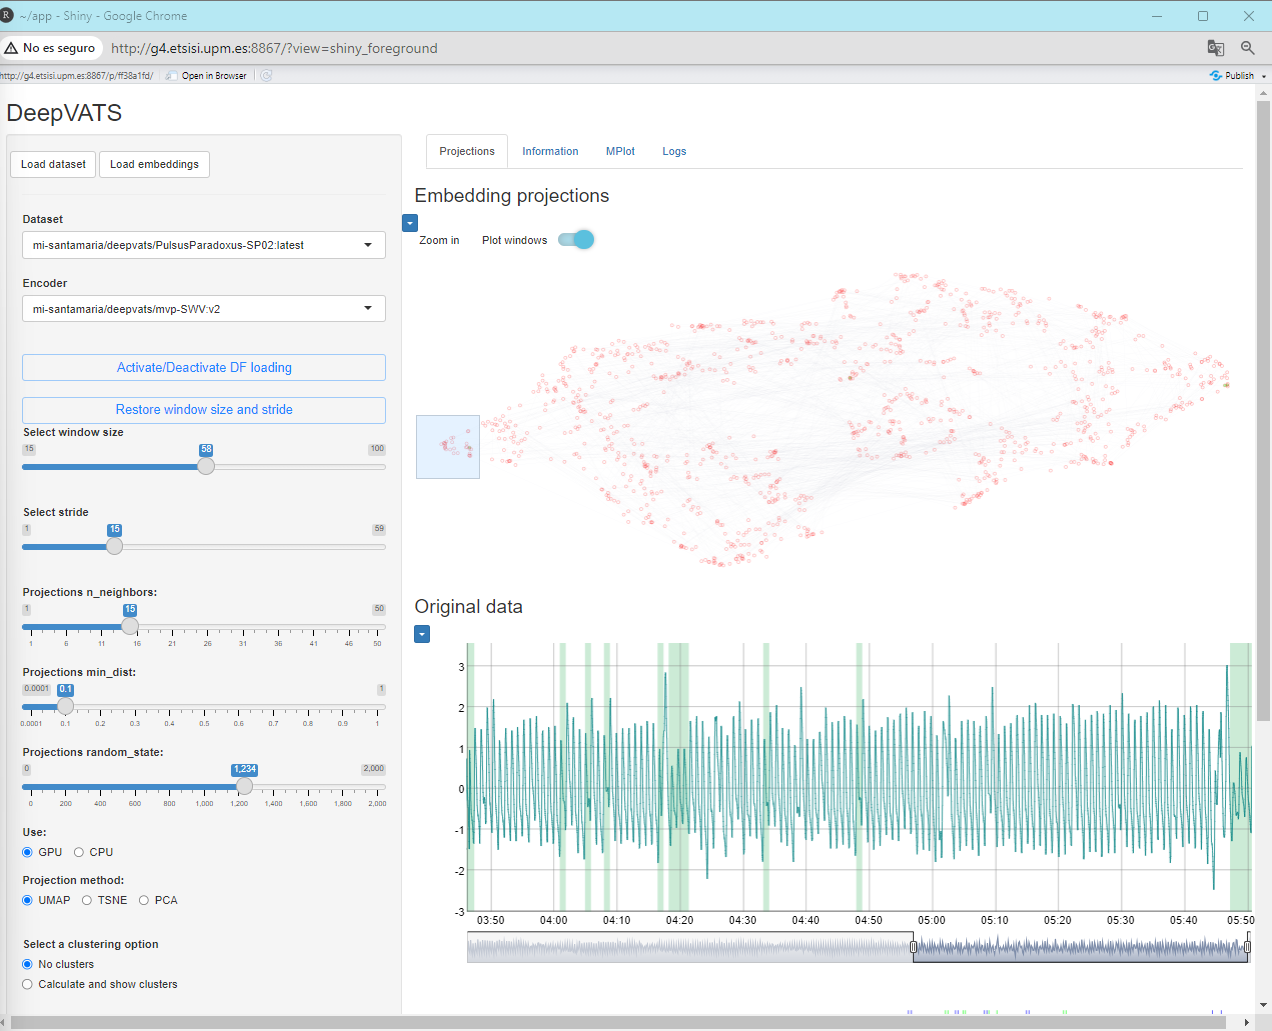

En las zonas antes del 10K y poco después se ve el inicio del pulsus paradoxus
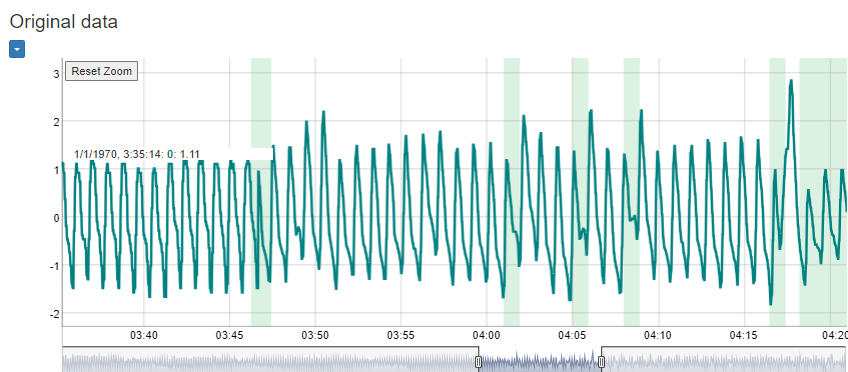

Y justo después... 

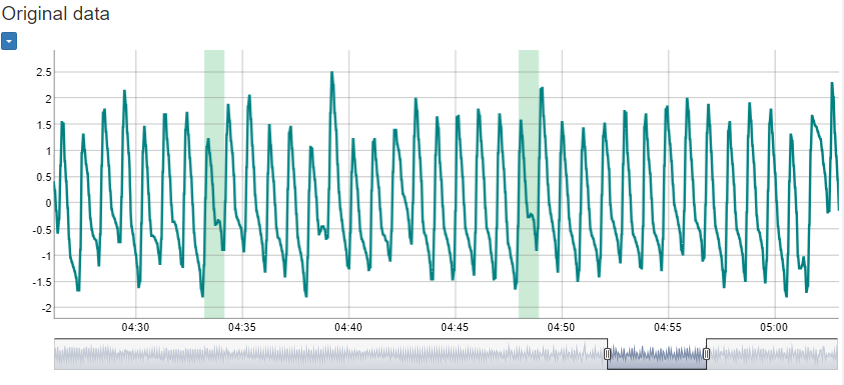

Parece que hemos encontrado un tipo de pulso en concreto cerca del 10k

In fact

In [ ]:
mplots.plot_subsequence(
    TA = ts[4500:5500], 
    sequence_i = 500,
    subsequence_len = pulsus_mp.subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    color = "blue",
    TA_color = "#CC0000"
)


It is exactly the subsequence next to the 10k! So near! Maybe the first fail?

Lets change a little bit the parameters t o see if clusters are more clear

By doing so I am detecting some more patterns near to the error: Those big mountains by the other side of the litle hands up
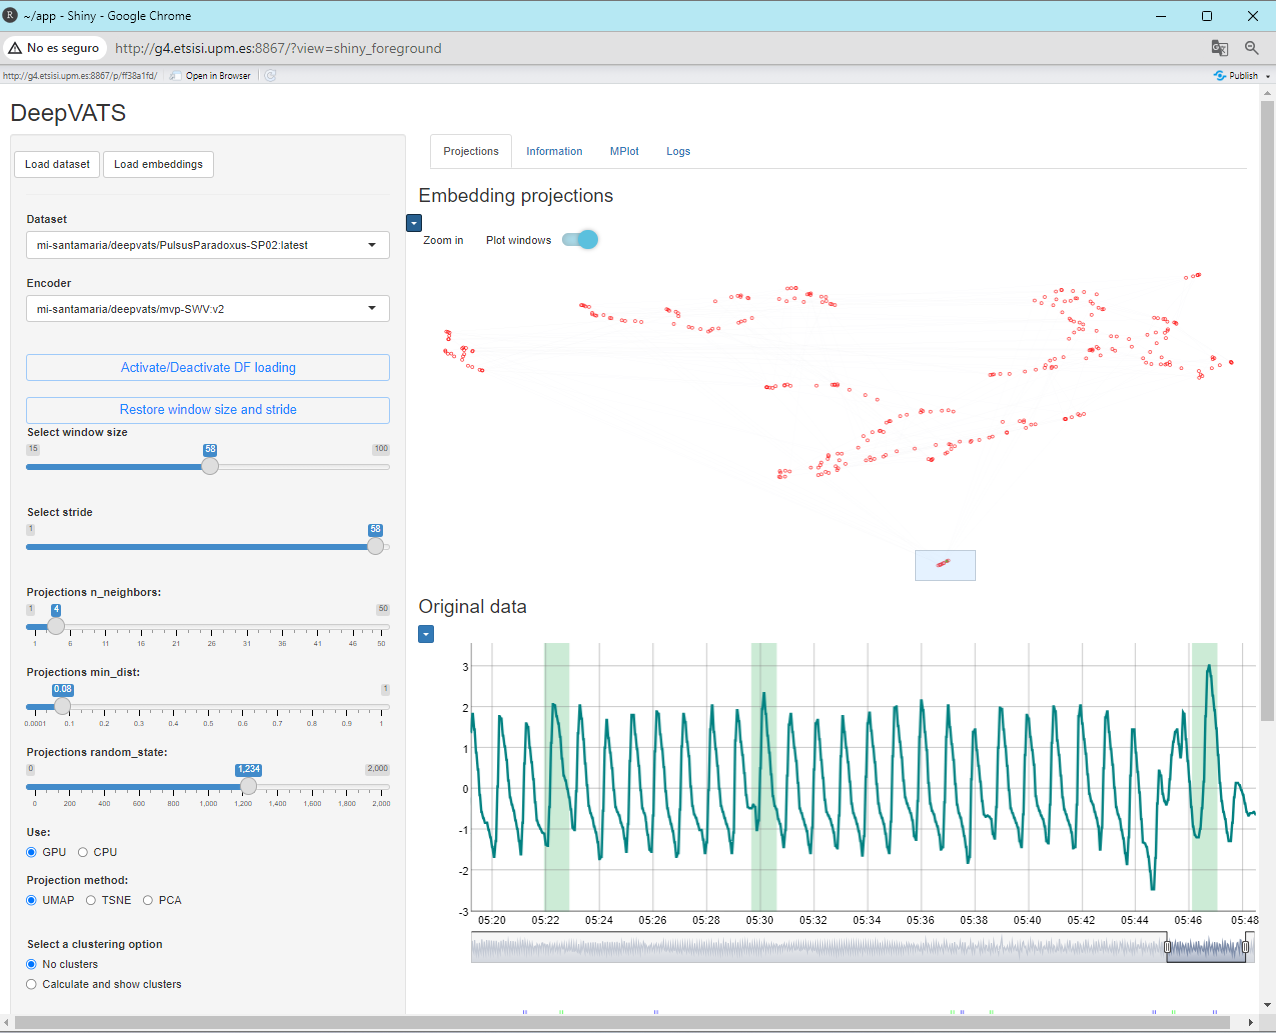

Lets compute clusters

- Blue group: kind of normal pulsus all across the time series
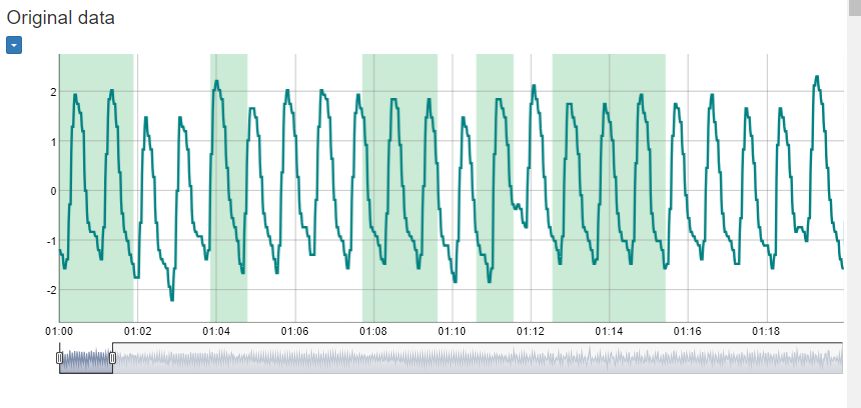




- Black down group: ¿Some kind of minimums?
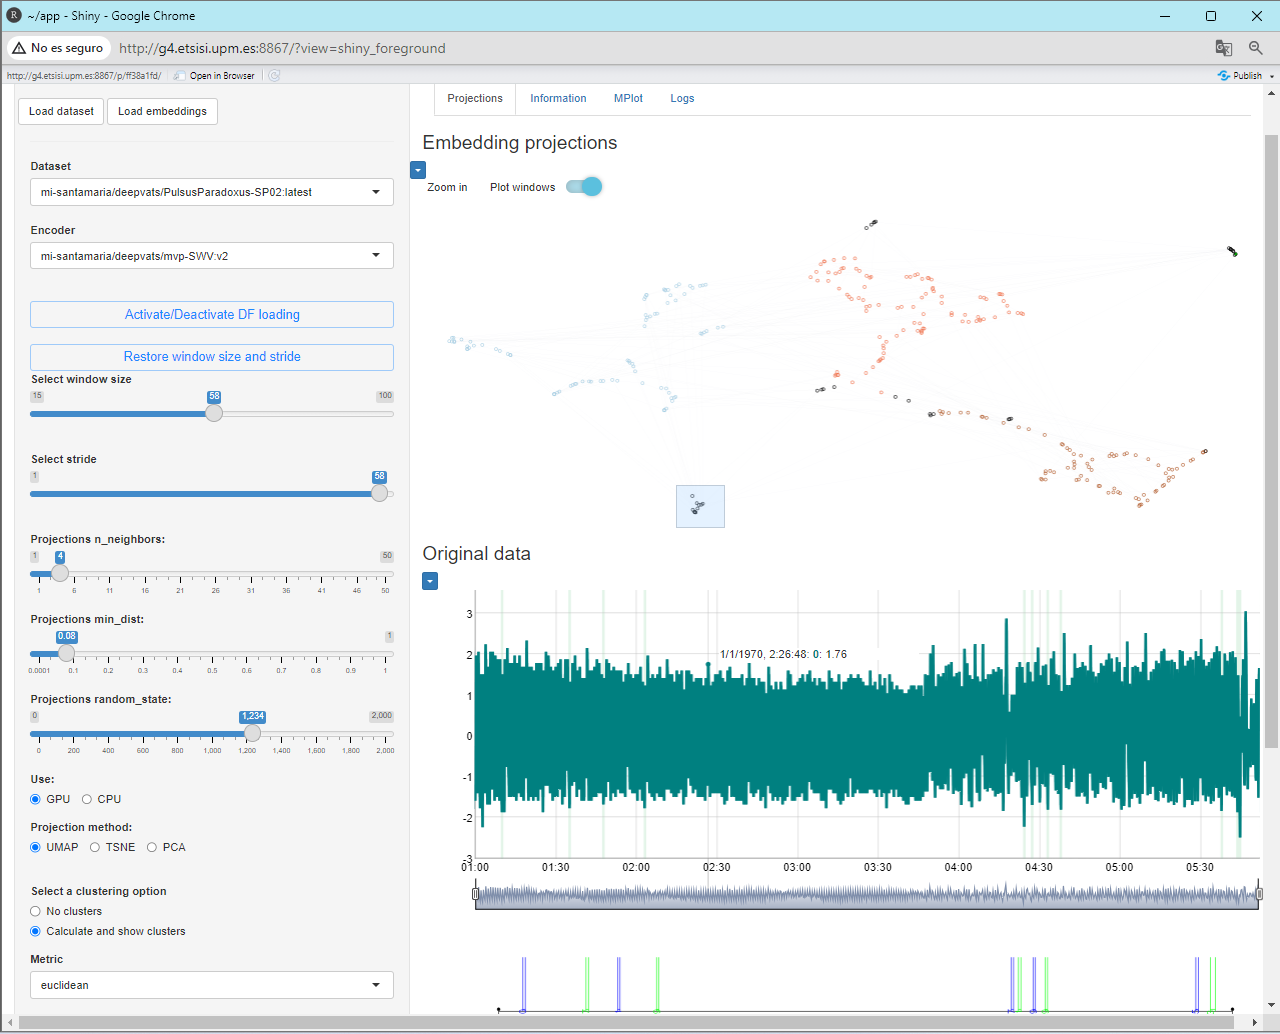
Always before an upper one

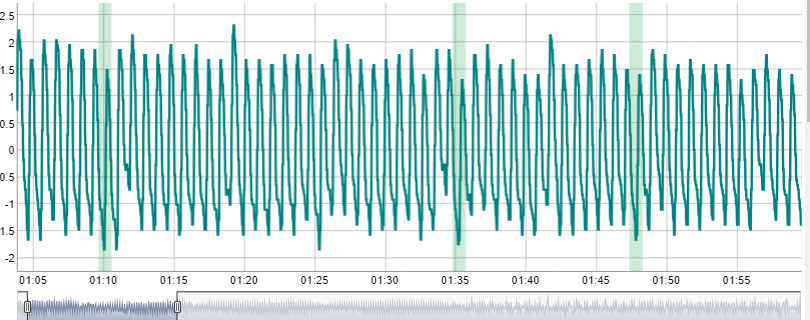
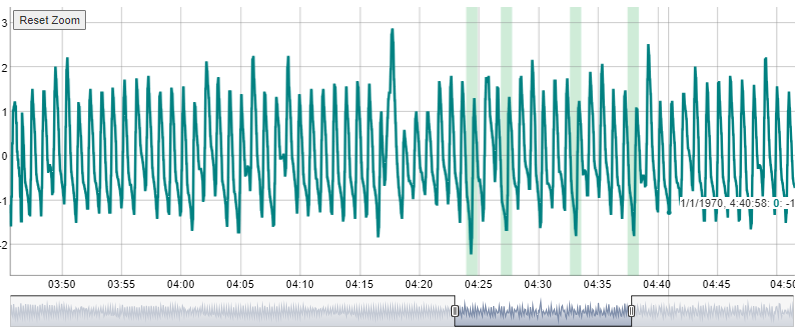
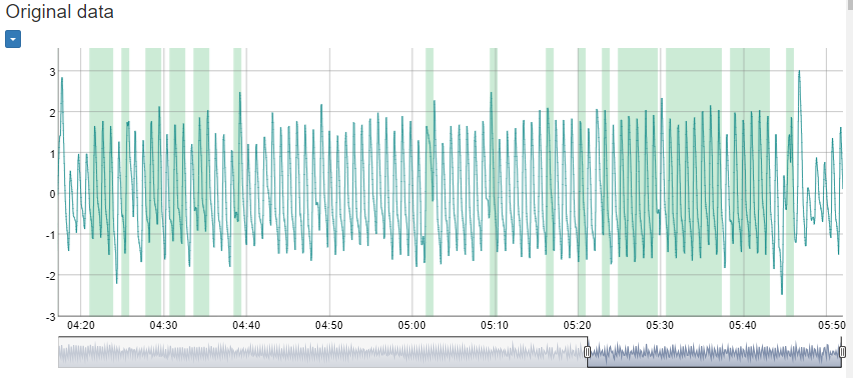


- El grupo pequeño justo antes del naranja parece simplemente un minimo un poco más alto, nada especialmente relevante
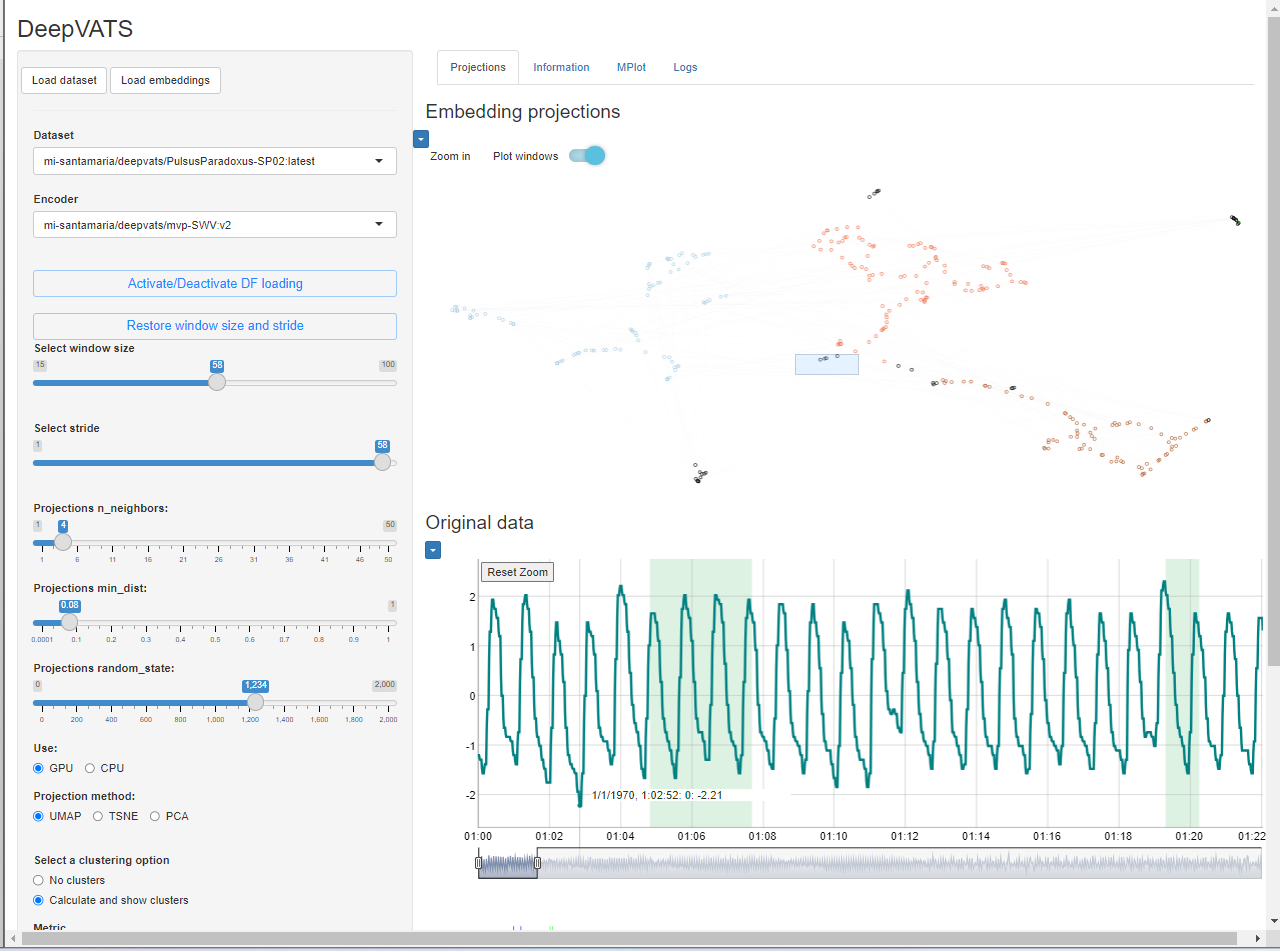
- El grupo naranja está por toda la serie temporal

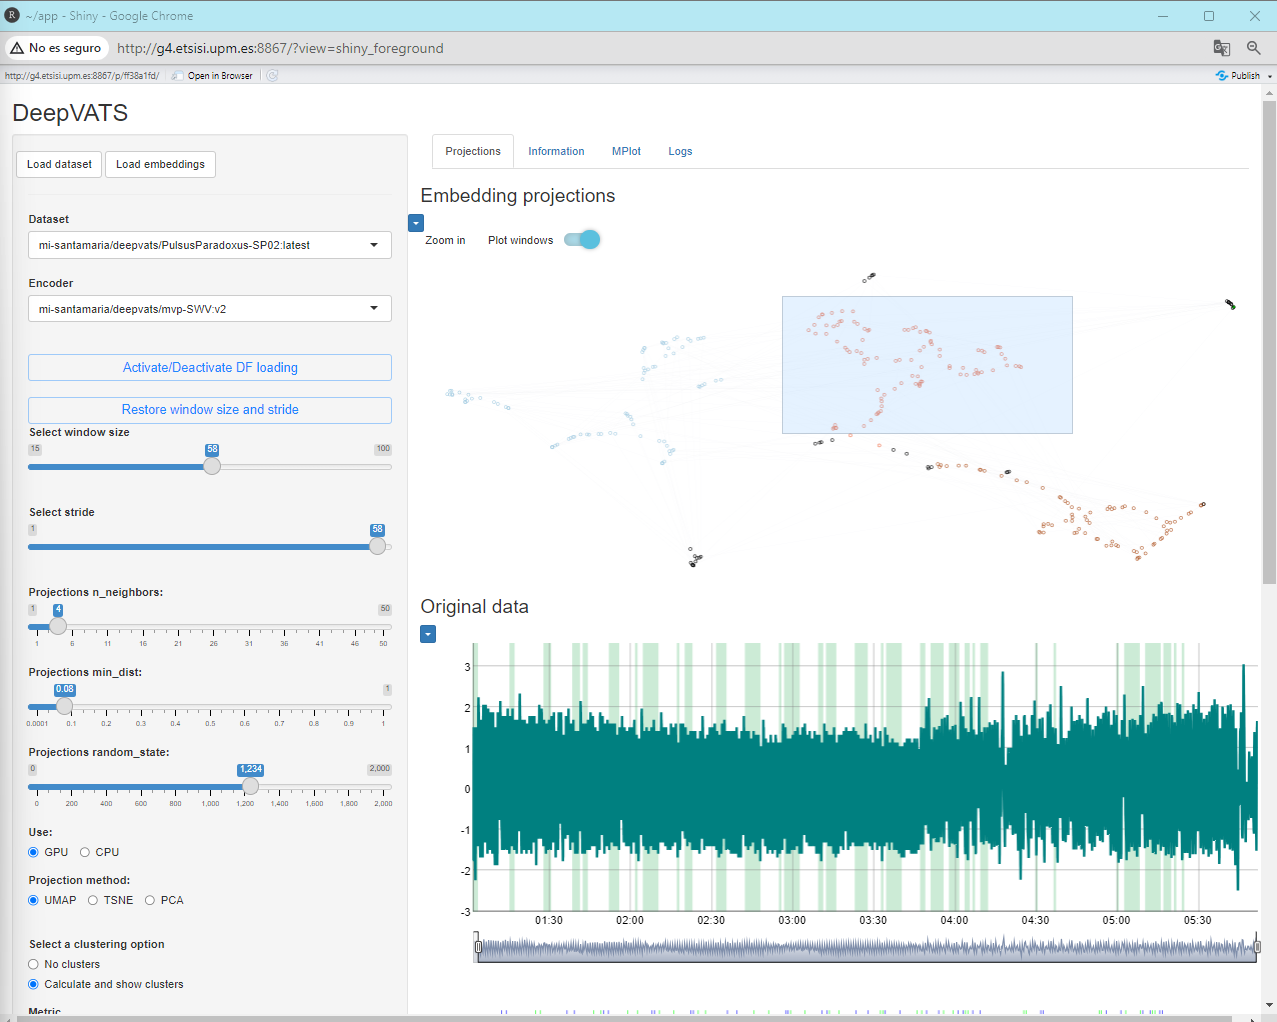


Parecen iguales que los azules pero con una caída más ancha por la derecha, como con más forma de capirote de semana santa

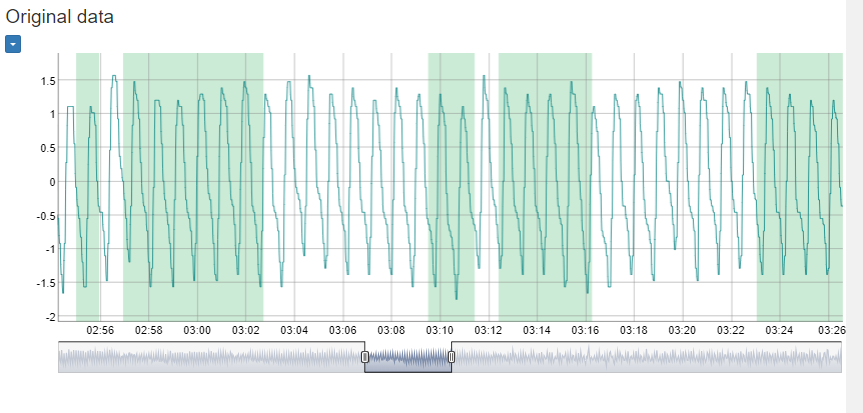
   

Anomalía extraña que aparece cerca del 10k pero también un poco antes

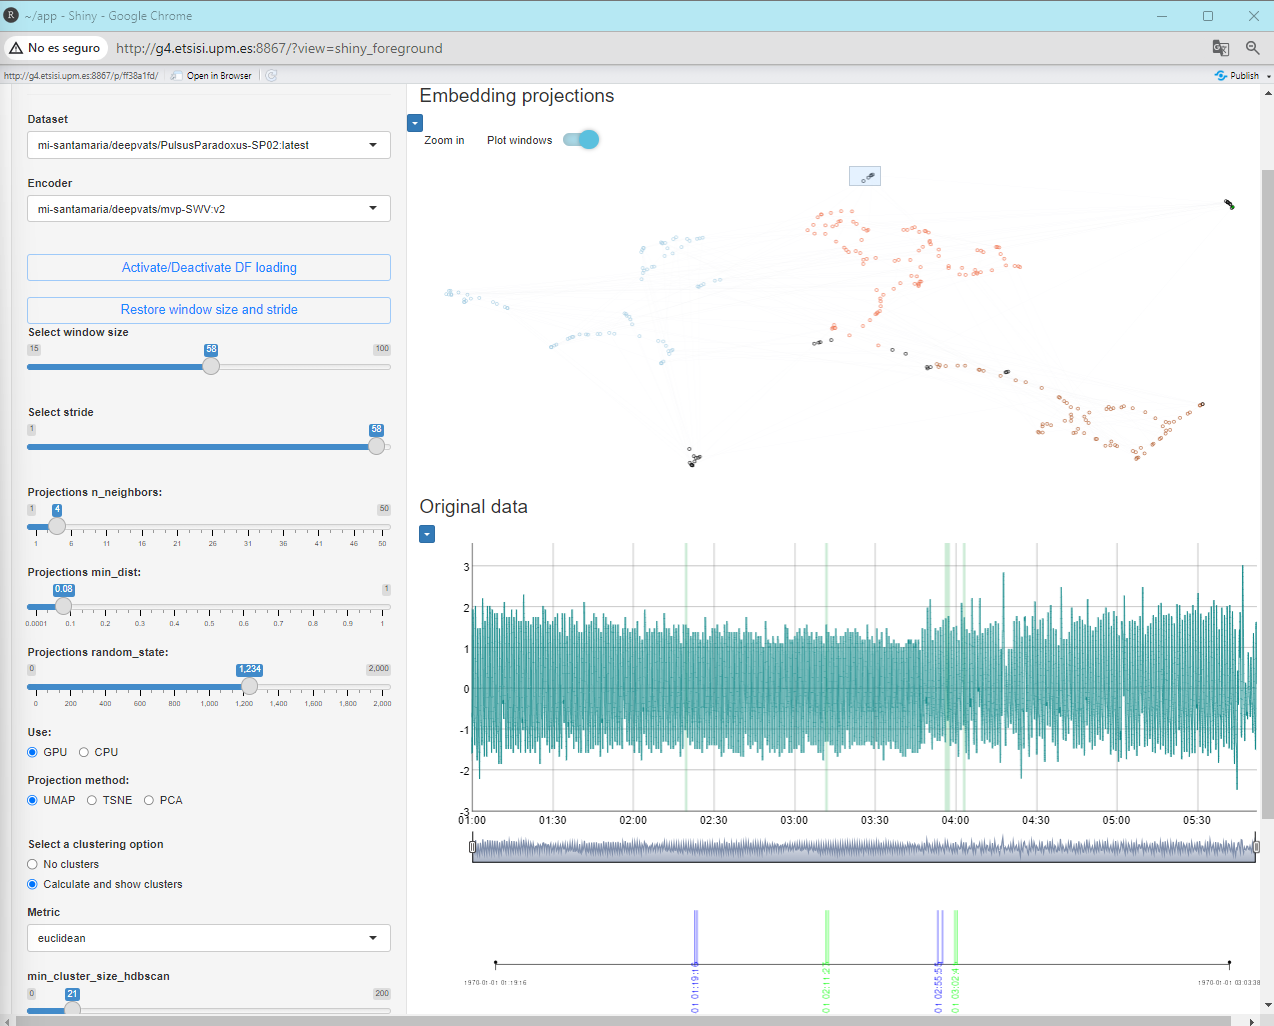

Por la forma y la cercanía al 10K del momento de la repetición, no descartaría que fuera el detonante del pulsus paradoxus:

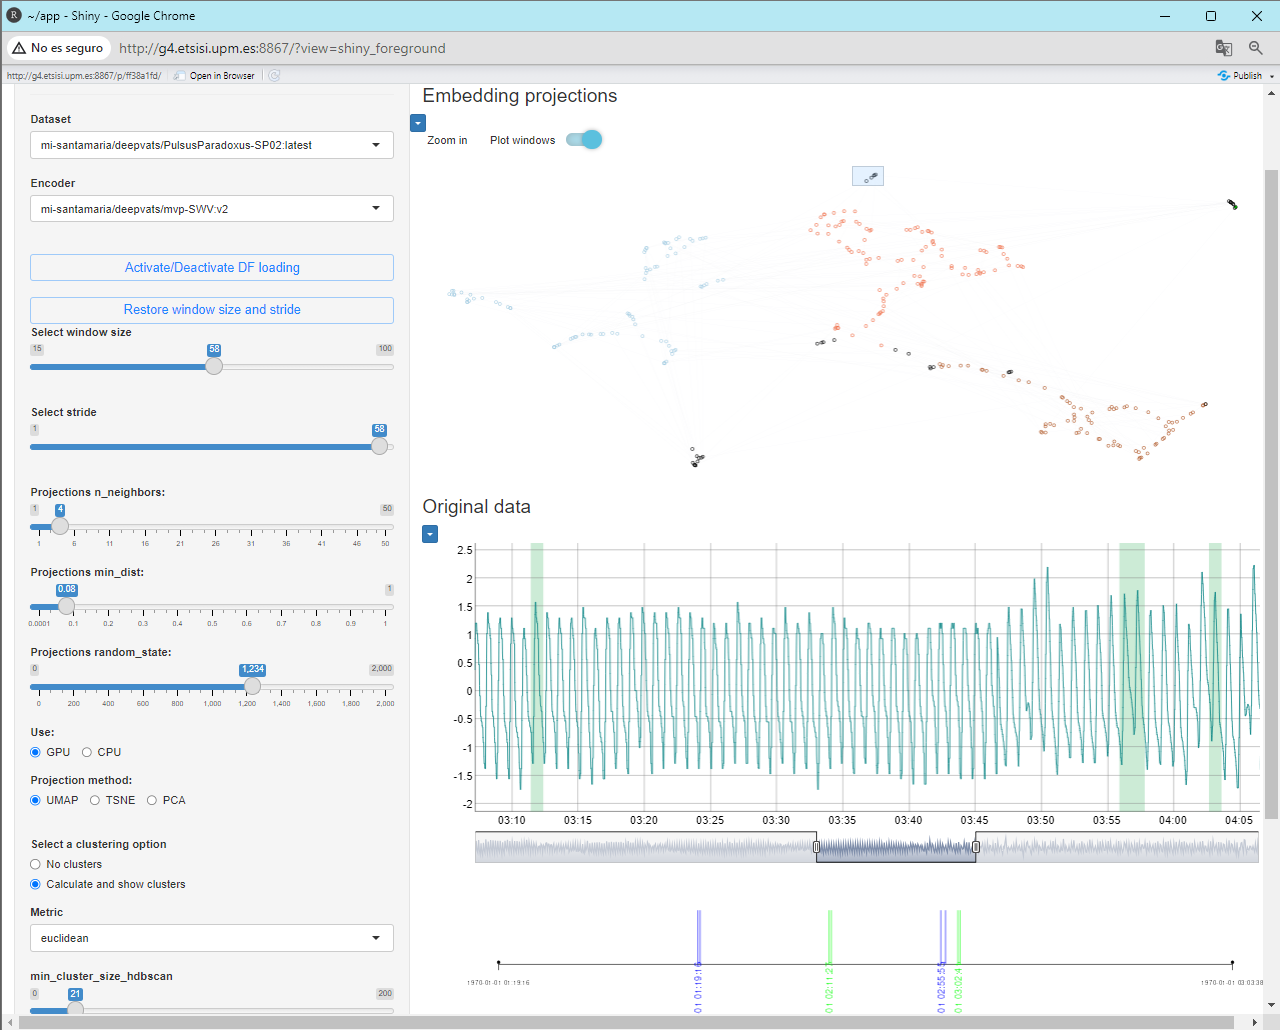

- El siguiente grupillo negro son unos picos menores, parecen una anomalía poco relevante

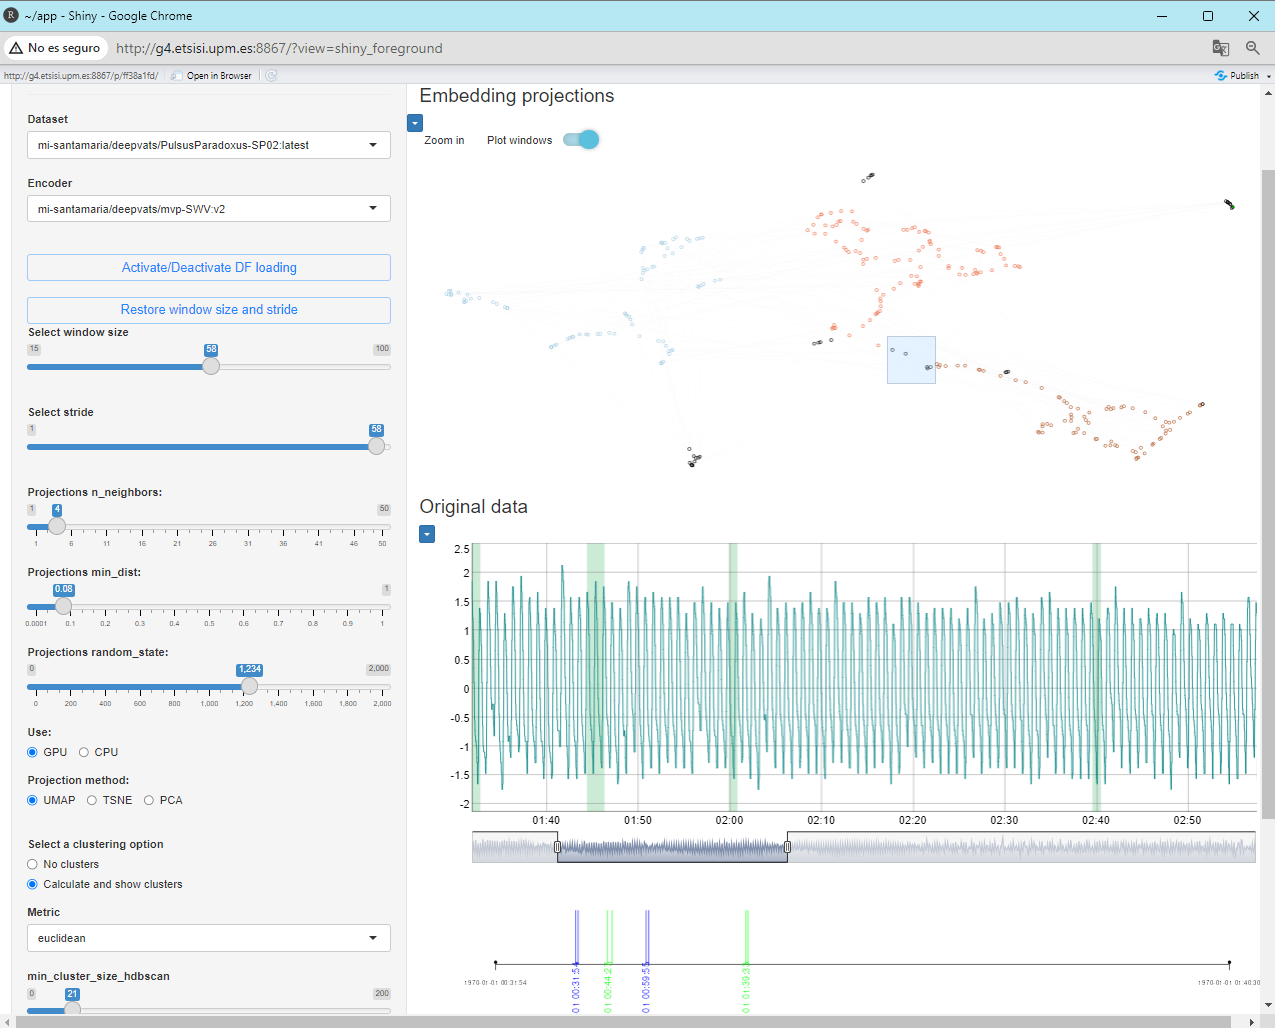
  
- Los marrones, aunque haya podido coger algun punto negro involuntariamente, parecen ser pulsos normales de otro tipo y más cercanos en el tiempo

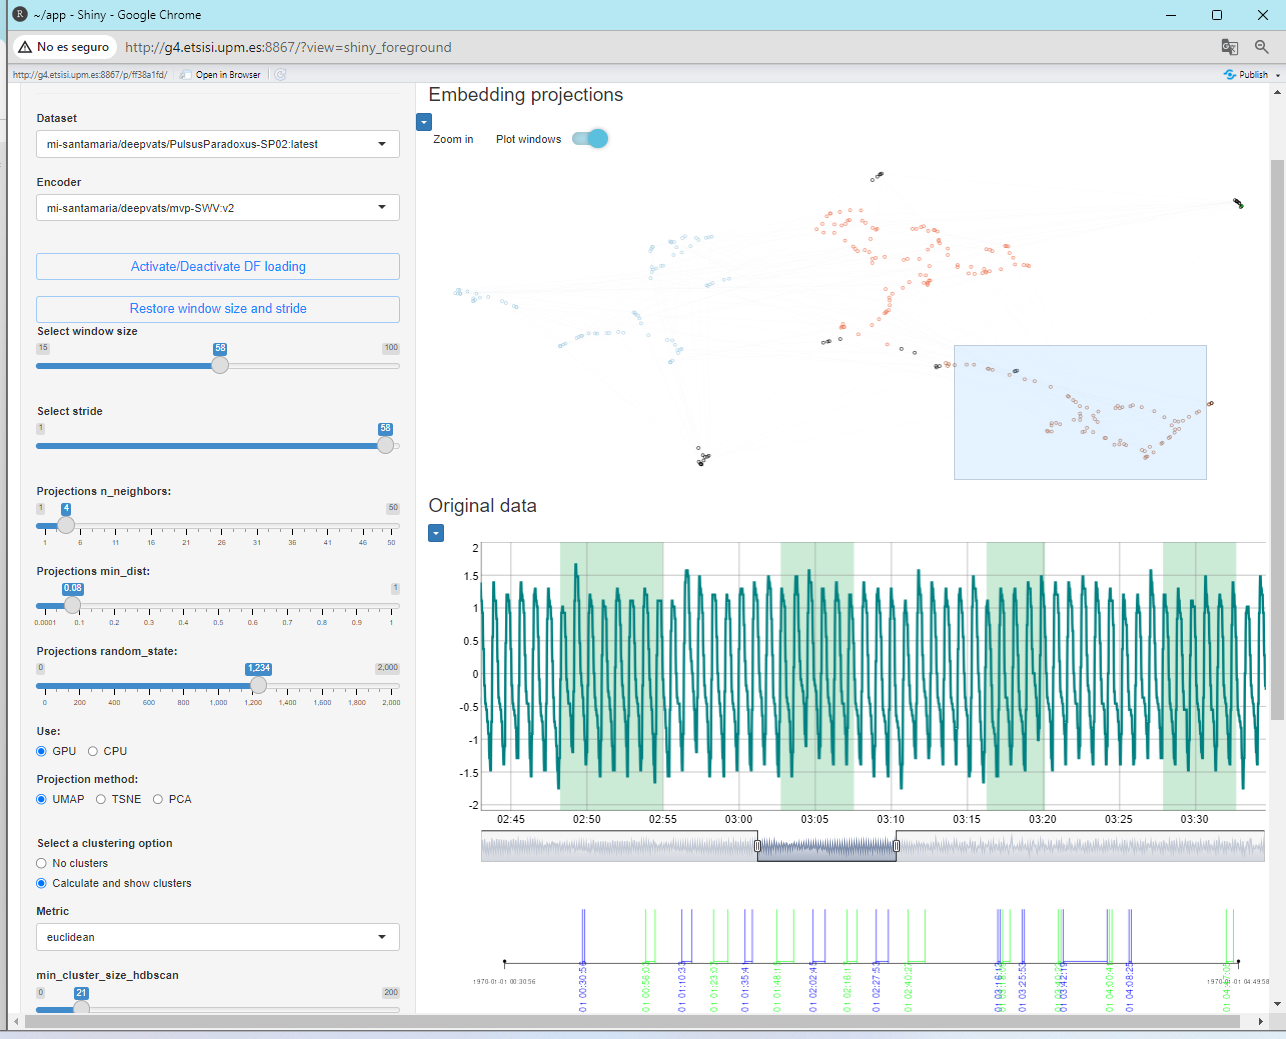

- 

Este parecen picos, pero no parece que nada de esto esté relacionado con el pulsus paradoxus per se, vamos a cambiar el método de proyeccuón a ver si conseguimos otra perspectiva

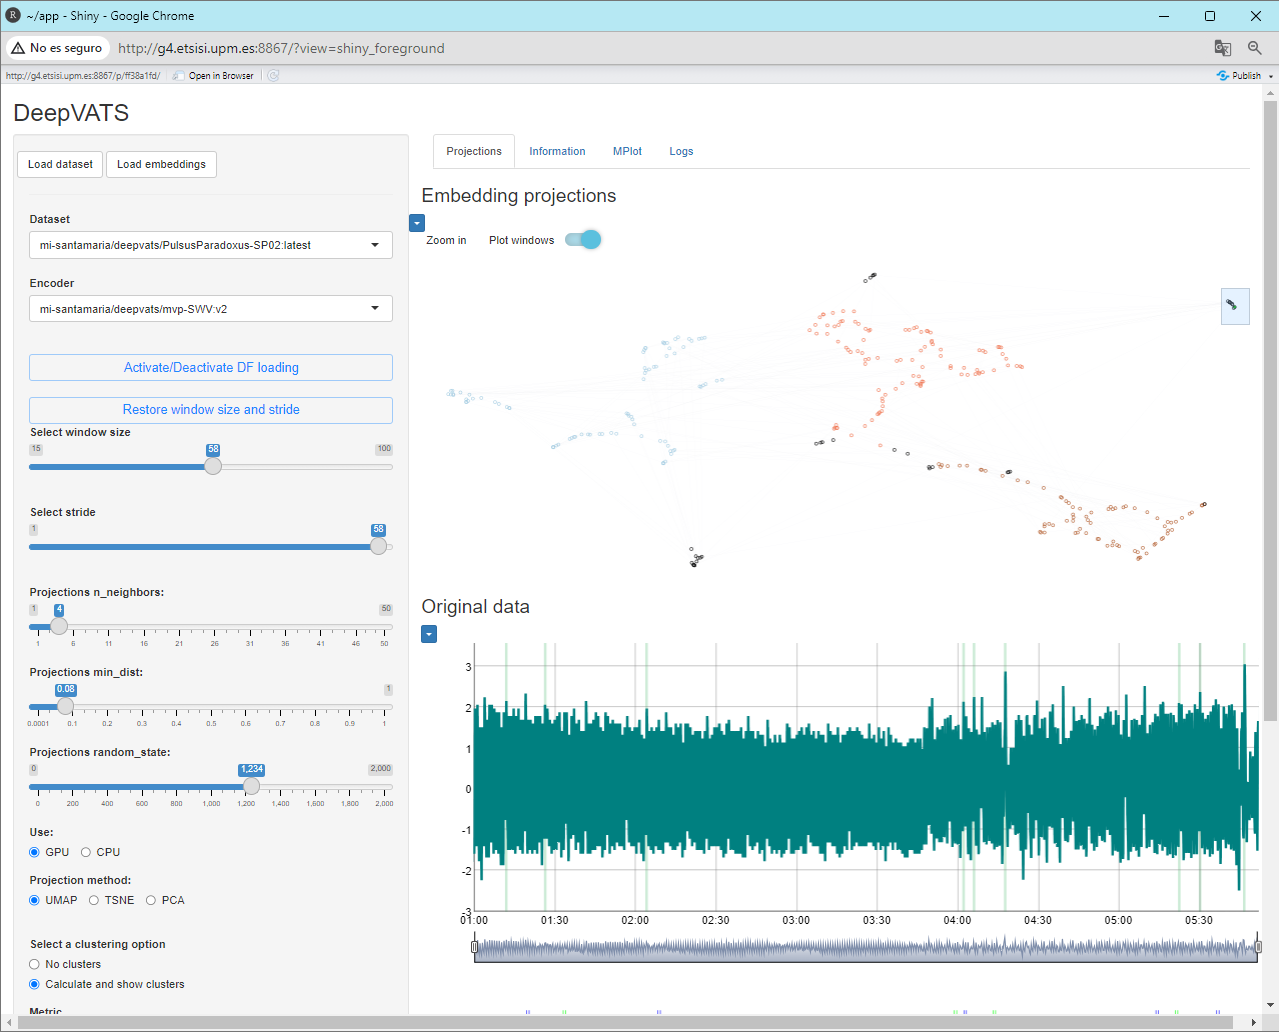

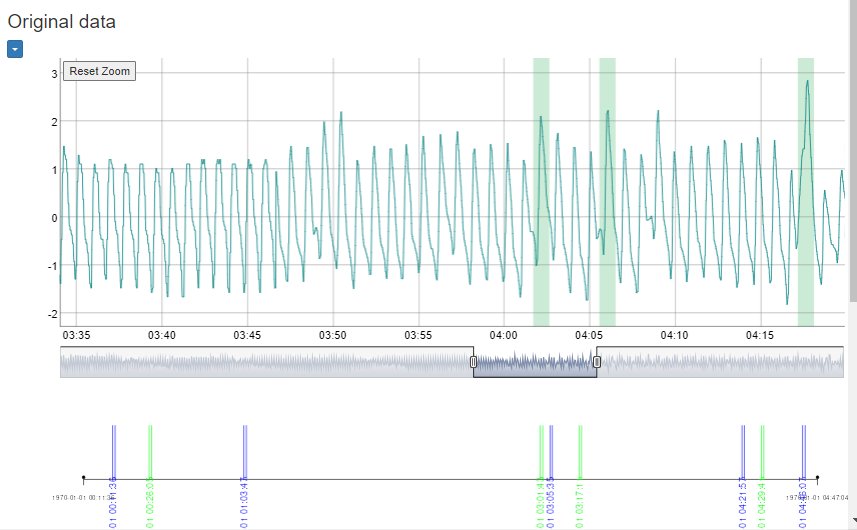